# Measure performance of cost functions

This is a topical tutorial. If you are new to iminuit, you should go through the basic tutorial first.

Here we measure the performance of the cost functions shipped with iminuit. We check that they produce unbiased results with proper variance. To do that, we generate normal distributed data many times and fit a normal distribution to each independent data set. The bias is computed from the averages of these reconstructed parameters. We also compute the mean of the estimated variance for each data set, which should converge to 1.

Since we do the fit many times, we do not use implementations of the pdf and cdf of a normal distribution from `scipy.stats`, but custom Numba-accelerated versions. For the binned fits, we compute histograms of the data with $3 + n/10$ equidistant bins, where $n$ is the sample size.

Disclaimer: This tutorial is targeted at experts, you are encouraged to read the code.

## Maximum-likelihood fits

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from iminuit import Minuit
from iminuit.cost import (
    UnbinnedNLL,
    BinnedNLL,
    ExtendedUnbinnedNLL,
    ExtendedBinnedNLL,
    LeastSquares,
)
from argparse import Namespace
import numba as nb
import math

In [2]:
n_tries = 10  # increase this to 100 to get less scattering

truth = Namespace(mu=0, sigma=1)

n_pts = np.array((10, 30, 100, 300, 1000, 3000, 10000))

kwd = {"parallel": True, "fastmath": True}

# custom faster computation of pdf and cdf of a normal distribution
@nb.njit(**kwd)
def norm_pdf(x, mu, sigma):
    invs = 1.0 / sigma
    z = (x - mu) * invs
    invnorm = 1 / np.sqrt(2 * np.pi) * invs
    return np.exp(-0.5 * z ** 2) * invnorm


@nb.njit(**kwd)
def nb_erf(x):
    y = np.empty_like(x)
    for i in nb.prange(len(x)):
        y[i] = math.erf(x[i])
    return y


@nb.njit(**kwd)
def norm_cdf(x, mu, sigma):
    invs = 1.0 / (sigma * np.sqrt(2))
    z = (x - mu) * invs
    return 0.5 * (1 + nb_erf(z))


@nb.njit
def norm_delta(xrange, mu, sigma):
    c = norm_cdf(xrange, mu, sigma)
    return c[1] - c[0]


# function that runs random experiments with sample size n
def compute(n):
    np.random.seed(n)
    u_nll = []
    b_nll = []
    e_u_nll = []
    e_b_nll = []
    for i_try in range(n_tries):
        while True:
            x = np.random.randn(2 * n)
            x = x[np.abs(x) < 2]
            x = x[:n]
            xrange = np.array((-2.0, 2.0))
            nh, xe = np.histogram(x, bins=3 + n // 10, range=xrange)
            m = [
                # model must be a normalized pdf
                Minuit(
                    UnbinnedNLL(
                        x,
                        lambda x, mu, sigma: (
                            norm_pdf(x, mu, sigma) / norm_delta(xrange, mu, sigma)
                        ),
                    ),
                    mu=truth.mu,
                    sigma=truth.sigma,
                ),
                # model must be a function that returns the integral over the scaled pdf and the scaled pdf
                Minuit(
                    ExtendedUnbinnedNLL(
                        x,
                        lambda x, n, mu, sigma: (
                            n * norm_delta(xrange, mu, sigma),
                            n * norm_pdf(x, mu, sigma),
                        ),
                    ),
                    n=n,
                    mu=truth.mu,
                    sigma=truth.sigma,
                ),
                # model must be a normalized cdf up to an arbitrary additive constant (only differences are used)
                Minuit(
                    BinnedNLL(
                        nh,
                        xe,
                        lambda x, mu, sigma: (
                            norm_cdf(x, mu, sigma) / norm_delta(xrange, mu, sigma)
                        ),
                    ),
                    mu=truth.mu,
                    sigma=truth.sigma,
                ),
                # model must be a scaled cdf up to an arbitrary additive constant (only differences are used)
                Minuit(
                    ExtendedBinnedNLL(
                        nh, xe, lambda x, n, mu, sigma: n * norm_cdf(x, mu, sigma)
                    ),
                    n=n,
                    mu=truth.mu,
                    sigma=truth.sigma,
                ),
            ]
            for mi in m:
                mi.limits["sigma"] = (1e-3, None)
                if "n" in mi.parameters:
                    mi.limits["n"] = (0, None)

            # only accept a random data set when all fits converged ok
            all_good = True
            for mi in m:
                mi.migrad()
                mi.hesse()
                if not mi.valid or not mi.accurate:
                    all_good = False
                    break
            if all_good:
                break
            print(f"{n} {i_try} need to re-try {[(mi.valid, mi.accurate) for mi in m]}")

        # store parameter deviations and estimated variances for each pseudo-experiment
        u_nll.append(
            (
                m[0].values["mu"] - truth.mu,
                m[0].errors["mu"] ** 2,
                m[0].values["sigma"] - truth.sigma,
                m[0].errors["sigma"] ** 2,
            )
        )
        e_u_nll.append(
            (
                m[1].values["n"] - n,
                m[1].errors["n"] ** 2,
                m[1].values["mu"] - truth.mu,
                m[1].errors["mu"] ** 2,
                m[1].values["sigma"] - truth.sigma,
                m[1].errors["sigma"] ** 2,
            )
        )
        b_nll.append(
            (
                m[2].values["mu"] - truth.mu,
                m[2].errors["mu"] ** 2,
                m[2].values["sigma"] - truth.sigma,
                m[2].errors["sigma"] ** 2,
            )
        )
        e_b_nll.append(
            (
                m[3].values["n"] - n,
                m[3].errors["n"] ** 2,
                m[3].values["mu"] - truth.mu,
                m[3].errors["mu"] ** 2,
                m[3].values["sigma"] - truth.sigma,
                m[3].errors["sigma"] ** 2,
            )
        )

    # means over pseudo-experiments are computed here
    return (
        np.mean(u_nll, axis=0),
        np.mean(e_u_nll, axis=0),
        np.mean(b_nll, axis=0),
        np.mean(e_b_nll, axis=0),
    )


unbinned_nll = []
extended_unbinned_nll = []
binned_nll = []
extended_binned_nll = []

# this could run in parallel, but the parallelization with processes fails on OSX where Apple messed up forks
for u, eu, b, eb in map(compute, n_pts):
    unbinned_nll.append(u)
    extended_unbinned_nll.append(eu)
    binned_nll.append(b)
    extended_binned_nll.append(eb)

unbinned_nll = np.transpose(unbinned_nll)
extended_unbinned_nll = np.transpose(extended_unbinned_nll)
binned_nll = np.transpose(binned_nll)
extended_binned_nll = np.transpose(extended_binned_nll)

We plot the measured bias as a point and the mean variance as an error bar. The deviations go down with $n^{-{1/2}}$, where $n$ is the sample size. We undo this for the plots by multiplying deviations with $n^{1/2}$.

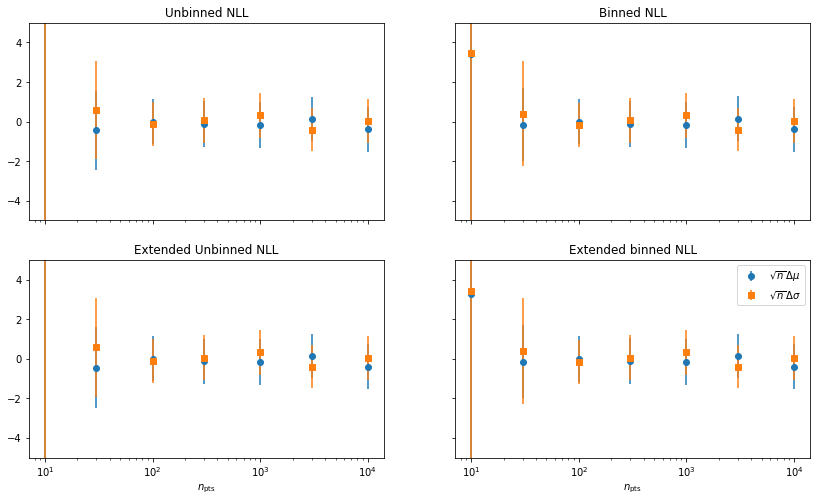

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)

plt.sca(ax[0, 0])
plt.title("Unbinned NLL")
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * unbinned_nll[0],
    np.sqrt(n_pts * unbinned_nll[1]),
    fmt="o",
    label=r"$\sqrt{n}\,\Delta\mu$",
)
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * unbinned_nll[2],
    np.sqrt(n_pts * unbinned_nll[3]),
    fmt="s",
    label=r"$\sqrt{n}\,\Delta\sigma$",
)

plt.sca(ax[0, 1])
plt.title("Binned NLL")
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * binned_nll[0],
    np.sqrt(n_pts * binned_nll[1]),
    fmt="o",
    label=r"$\sqrt{n}\,\Delta\mu$",
)
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * binned_nll[2],
    np.sqrt(n_pts * binned_nll[3]),
    fmt="s",
    label=r"$\sqrt{n}\,\Delta\sigma$",
)

plt.sca(ax[1, 0])
plt.title("Extended Unbinned NLL")
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * extended_unbinned_nll[2],
    np.sqrt(n_pts * extended_unbinned_nll[3]),
    fmt="o",
    label=r"$\sqrt{n}\,\Delta\mu$",
)
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * extended_unbinned_nll[4],
    np.sqrt(n_pts * extended_unbinned_nll[5]),
    fmt="s",
    label=r"$\sqrt{n}\,\Delta\sigma$",
)

plt.sca(ax[1, 1])
plt.title("Extended binned NLL")
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * extended_binned_nll[2],
    np.sqrt(n_pts * extended_binned_nll[3]),
    fmt="o",
    label=r"$\sqrt{n}\,\Delta\mu$",
)
plt.errorbar(
    n_pts,
    n_pts ** 0.5 * extended_binned_nll[4],
    np.sqrt(n_pts * extended_binned_nll[5]),
    fmt="s",
    label=r"$\sqrt{n}\,\Delta\sigma$",
)

plt.ylim(-5, 5)
plt.legend()
for i in (0, 1):
    ax[1, i].set_xlabel(r"$n_\mathrm{pts}$")
plt.semilogx();

## Least-squares fits (aka chisquare fit)

We do the same as before, but this time we use a least-squares fit of $x,y$ scattered data and vary the residual function. Other functions than the identity can be used to reduce the pull of large outliers.

In [4]:
n_tries = 10  # increase this to 500 to get less scattering

truth = Namespace(a=1, b=2)

n_pts = np.array((10, 30, 100, 300, 1000, 3000, 10000))


def compute(n):
    np.random.seed(n)
    x = np.linspace(0, 1, n)

    linear = []
    soft_l1 = []
    arctan = []
    for i_try in range(n_tries):

        def model(x, a, b):
            return np.exp(a + b * x)

        while True:
            y = model(x, 1, 2)
            ye = 0.1
            y += ye * np.random.randn(len(y))

            m = [
                Minuit(LeastSquares(x, y, ye, model), a=0, b=0),
                Minuit(LeastSquares(x, y, ye, model, loss="soft_l1"), a=0, b=0),
                Minuit(LeastSquares(x, y, ye, model, loss=np.arctan), a=0, b=0),
            ]

            all_good = True
            for mi in m:
                mi.migrad()
                mi.hesse()
                if not mi.valid or not mi.accurate:
                    all_good = False
                    break
            if all_good:
                break
            print(f"{n} {i_try} need to re-try {[(mi.valid, mi.accurate) for mi in m]}")

        linear.append(
            (
                m[0].values["a"] - truth.a,
                m[0].errors["a"] ** 2,
                m[0].values["b"] - truth.b,
                m[0].errors["b"] ** 2,
            )
        )
        soft_l1.append(
            (
                m[1].values["a"] - truth.a,
                m[1].errors["a"] ** 2,
                m[1].values["b"] - truth.b,
                m[1].errors["b"] ** 2,
            )
        )
        arctan.append(
            (
                m[2].values["a"] - truth.a,
                m[2].errors["a"] ** 2,
                m[2].values["b"] - truth.b,
                m[2].errors["b"] ** 2,
            )
        )
    return np.mean(linear, axis=0), np.mean(soft_l1, axis=0), np.mean(arctan, axis=0)


linear = []
soft_l1 = []
arctan = []

for l, s, a in map(compute, n_pts):
    linear.append(l)
    soft_l1.append(s)
    arctan.append(a)

linear = np.transpose(linear)
soft_l1 = np.transpose(soft_l1)
arctan = np.transpose(arctan)

10 6 need to re-try [(True, True), (True, True), (True, False)]
10 8 need to re-try [(True, True), (True, True), (True, False)]
10 9 need to re-try [(True, True), (True, True), (True, False)]
10 9 need to re-try [(True, True), (True, True), (True, False)]


<ipython-input-4-1ad2cd92403f>:18: RuntimeWarning: overflow encountered in exp
  return np.exp(a + b * x)


3000 8 need to re-try [(True, True), (True, True), (True, False)]


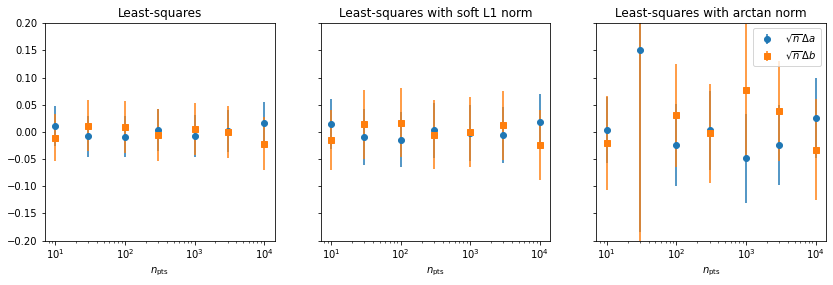

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

for axi, title, func in (
    (ax[0], "Least-squares", linear),
    (ax[1], "Least-squares with soft L1 norm", soft_l1),
    (ax[2], "Least-squares with arctan norm", arctan),
):
    plt.sca(axi)
    plt.title(title)
    plt.errorbar(
        n_pts,
        n_pts ** 0.5 * func[0],
        np.sqrt(n_pts * func[1]),
        fmt="o",
        label=r"$\sqrt{n}\,\Delta a$",
    )
    plt.errorbar(
        n_pts,
        n_pts ** 0.5 * (func[2]),
        np.sqrt(n_pts * func[3]),
        fmt="s",
        label=r"$\sqrt{n}\,\Delta b$",
    )

plt.ylim(-0.2, 0.2)
plt.legend()
for axi in ax:
    axi.set_xlabel(r"$n_\mathrm{pts}$")
plt.semilogx();